In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, kruskal
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Google Colab에서 한글 표시용)
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")

# 1. 데이터 로드
try:
    # Google Colab에서 파일을 업로드한 경우
    df = pd.read_csv('/content/final_dataset_integrated_features.csv', encoding = 'utf-8')
    print("✅ 데이터 로드 성공!")
except:
    print("❌ Error - No data found")
    exit()

# 중구 데이터 삭제
df.drop(index=23, inplace=True)

✅ 데이터 로드 성공!


In [9]:
# 클러스터 할당
cluster_mapping = {
    # Cluster 4
    'Gangnam': 4, 'Yeongdeungpo': 4,

    # Cluster 1
    'Eunpyeong': 1, 'Seongbuk': 1, 'Jungnang': 1, 'Gangbuk': 1, 'Nowon': 1, 'Dobong': 1,

    # Cluster 3
    'Gwangjin': 3, 'Yangcheon': 3, 'Guro': 3, 'Yongsan': 3, 'Gangseo': 3, 'Geumcheon': 3,

    # Cluster 2
    'Gangdong': 2, 'Jongno': 2, 'Gwanak': 2, 'Dongdaemun': 2, 'Seocho': 2,
    'Songpa': 2, 'Seodaemun': 2, 'Dongjak': 2, 'Mapo': 2, 'Seongdong': 2
}

# 클러스터 정보 추가
df['Cluster'] = df['District'].map(cluster_mapping)

print("=== 클러스터별 범죄밀도 분석 ===\n")

# 1. 기본 통계량
print("1. 클러스터별 범죄밀도 기본 통계량")
print("="*50)
cluster_stats = df.groupby('Cluster')['Crime_Density'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(4)
cluster_stats.columns = ['구 개수', '평균', '표준편차', '최솟값', '최댓값', '중앙값']
print(cluster_stats)
print()

# 2. 각 클러스터별 세부 정보
print("2. 클러스터별 세부 정보")
print("="*50)
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\n** Cluster {cluster} **")
    print(f"구: {', '.join(cluster_data['District'].tolist())}")
    print(f"범죄밀도 평균: {cluster_data['Crime_Density'].mean():.4f}")
    print(f"범죄밀도 표준편차: {cluster_data['Crime_Density'].std():.4f}")
    crime_values = cluster_data[['District', 'Crime_Density']].sort_values('Crime_Density', ascending=False)
    for _, row in crime_values.iterrows():
        print(f"  - {row['District']}: {row['Crime_Density']:.4f}")

=== 클러스터별 범죄밀도 분석 ===

1. 클러스터별 범죄밀도 기본 통계량
         구 개수        평균     표준편차    최솟값     최댓값      중앙값
Cluster                                                 
1           6   66.3700  16.9591  52.11   96.59   58.130
2          10   77.8730  16.8757  51.27  103.45   76.640
3           6   88.9333  19.2038  58.84  110.14   91.075
4           2  100.9900   3.7618  98.33  103.65  100.990

2. 클러스터별 세부 정보

** Cluster 1 **
구: Gangbuk, Nowon, Dobong, Seongbuk, Eunpyeong, Jungnang
범죄밀도 평균: 66.3700
범죄밀도 표준편차: 16.9591
  - Jungnang: 96.5900
  - Gangbuk: 76.2300
  - Seongbuk: 58.9100
  - Eunpyeong: 57.3500
  - Nowon: 57.0300
  - Dobong: 52.1100

** Cluster 2 **
구: Gangdong, Gwanak, Dongdaemun, Dongjak, Mapo, Seodaemun, Seocho, Seongdong, Songpa, Jongno
범죄밀도 평균: 77.8730
범죄밀도 표준편차: 16.8757
  - Dongdaemun: 103.4500
  - Mapo: 101.8900
  - Gwanak: 88.6000
  - Dongjak: 82.6400
  - Songpa: 80.9300
  - Gangdong: 72.3500
  - Seongdong: 67.6000
  - Jongno: 67.2100
  - Seodaemun: 62.7900
  - Seocho: 51.2700

*

In [5]:
# 3. 통계적 유의성 검정
print("\n3. 통계적 유의성 검정")
print("="*50)

# 각 클러스터별 범죄밀도 데이터 분리
cluster_groups = []
for cluster in sorted(df['Cluster'].unique()):
    cluster_groups.append(df[df['Cluster'] == cluster]['Crime_Density'].values)

# 정규성 검정 (Shapiro-Wilk)
print("정규성 검정 (Shapiro-Wilk test):")
for i, cluster in enumerate(sorted(df['Cluster'].unique())):
    stat, p_value = stats.shapiro(cluster_groups[i])
    print(f"Cluster {cluster}: p-value = {p_value:.4f} ({'정규분포' if p_value > 0.05 else '비정규분포'})")

# ANOVA vs Kruskal-Wallis 검정
print(f"\n분산 분석:")
# ANOVA (정규분포 가정)
f_stat, p_anova = f_oneway(*cluster_groups)
print(f"ANOVA F-통계량: {f_stat:.4f}, p-value: {p_anova:.4f}")

# Kruskal-Wallis (비모수 검정)
kw_stat, p_kruskal = kruskal(*cluster_groups)
print(f"Kruskal-Wallis H-통계량: {kw_stat:.4f}, p-value: {p_kruskal:.4f}")

# 결과 해석
alpha = 0.10
print(f"\n** 결과 해석 (α = {alpha}) **")
if p_anova < alpha or p_kruskal < alpha:
    print("✅ 클러스터 간 범죄밀도에 통계적으로 유의미한 차이가 있습니다.")
else:
    print("❌ 클러스터 간 범죄밀도에 통계적으로 유의미한 차이가 없습니다.")


3. 통계적 유의성 검정
정규성 검정 (Shapiro-Wilk test):
Cluster 1: p-value = nan (비정규분포)
Cluster 2: p-value = 0.0720 (정규분포)
Cluster 3: p-value = 0.5757 (정규분포)
Cluster 4: p-value = 0.7729 (정규분포)

분산 분석:
ANOVA F-통계량: 2.8645, p-value: 0.0624
Kruskal-Wallis H-통계량: 7.3387, p-value: 0.0619

** 결과 해석 (α = 0.1) **
✅ 클러스터 간 범죄밀도에 통계적으로 유의미한 차이가 있습니다.


In [10]:
# 4. 사후 검정 (Tukey HSD)
if p_anova < alpha:
    print("\n4. 사후 검정 (Tukey HSD)")
    print("="*50)
    from scipy.stats import tukey_hsd

    try:
        tukey_result = tukey_hsd(*cluster_groups)
        print("클러스터 간 쌍별 비교:")
        clusters = sorted(df['Cluster'].unique())
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                p_val = tukey_result.pvalue[i, j]
                significance = "유의함" if p_val < alpha else "유의하지 않음"
                print(f"Cluster {clusters[i]} vs Cluster {clusters[j]}: p-value = {p_val:.4f} ({significance})")
    except:
        print("Tukey HSD 검정을 수행할 수 없습니다. (샘플 크기 부족)")


4. 사후 검정 (Tukey HSD)
클러스터 간 쌍별 비교:
Cluster 1 vs Cluster 2: p-value = 0.0945 (유의함)
Cluster 1 vs Cluster 3: p-value = 0.8237 (유의하지 않음)
Cluster 1 vs Cluster 4: p-value = 0.3286 (유의하지 않음)
Cluster 2 vs Cluster 3: p-value = 0.1356 (유의하지 않음)
Cluster 2 vs Cluster 4: p-value = 0.5726 (유의하지 않음)
Cluster 3 vs Cluster 4: p-value = 0.6029 (유의하지 않음)


Text(0, 0.5, 'Criminal_Density')

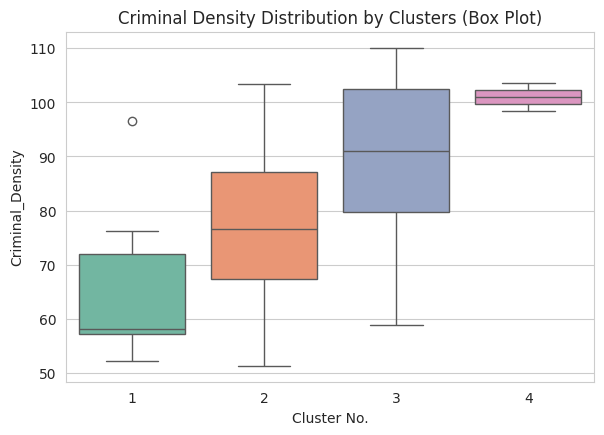

In [11]:
# 5. 시각화
plt.figure(figsize=(15, 10))

# 5-1. 박스플롯
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='Cluster', y='Crime_Density', palette='Set2')
plt.title('Criminal Density Distribution by Clusters (Box Plot)')
plt.xlabel('Cluster No.')
plt.ylabel('Criminal_Density')